# Fine Tuning the Resnet for Optimization Of Results

This notebook will comprise some small suggested changes, as an attempt to create a simple but efficient ResNet training loop.

Throughout this file, I will implement:

 - Best validation loss model output, to maximize model performance
 - Unfreezing layers, as an attempt to allow the ResNet to adapt to the dataset
 - Adding performance metrics and plotting ROC/AUC for the test dataframe, for more thorough evaluation
 - Resizing tensors before augmentations, to increase training speed 

Firstly, I will import code snippets from `resnetEval.ipynb`:

In [1]:
# -----------  General -----------

from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc
from scipy.ndimage import gaussian_filter
import torch.nn.functional as F
import matplotlib.pyplot as plt
import albumentations as A
from tqdm import tqdm
import pandas as pd
import numpy as np
import pickle
import random
import math
import copy
import os


# -----------  Utility -----------

from fineTuneUtils import *

# -----------  ResNet -----------

# Core library
import torch

# Essentials for development
import torch.nn as nn
import torchvision.models as models
from torchvision.models import ResNet18_Weights

# Data resize (ResNet uses (224,224) inputs)
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor

# Allows for paralell batch processing
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.io import decode_image

# Data Loader Design

The first step in optimization has already been implemented: resizing before applying augmentations.

In [44]:
class FibrosisDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None, albumentations=None, gauss=False):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.albumentations = albumentations
        self.gauss = gauss

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        # idx represents index
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])

        # Load the .npy file
        image = np.load(img_path)
        
        #image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]

        # Adds random set of augmentations
        if self.albumentations:
            # Applies resize prior to augmentations
            # Could hinder scan quality, but drastically improves training speed
            resize = transforms.Resize((224, 224))
            image = resize(image)
            augmented = self.albumentations(image=image)
            image = augmented['image']

        # Adds randomly selected gauss noise or blur
        if self.gauss:
            # Gaussian Noise
            gauss_noise = image + np.random.normal(loc=0, scale=random.choice(range(10,40)), size=image.shape)
            # Gaussian Blur
            gauss_blur = gaussian_filter(image, sigma=(random.choice(range(10,16))/10)) 
            # Random choice
            image = random.choice((gauss_noise,gauss_blur))

        # Guarantee compatibility
        if self.gauss or self.albumentations: image = image.astype(np.float32)

        # Applies necessary ResNet input transformations
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        
        return image, label

## Main Functions

**trainResNet** is the next subject to change. First, I must evaluate which is the best option:

```py

    # Considers only absolute lowest val_loss value
    best_model_pure = resnet18

    # Considers balance between good loss value and reasonable training loss
    best_model_conservative = resnet18

```

The first option should be more prone to overfitting. For this reason, I will be evaluating if defining a threshold for loss improvement in model choice results in better performance.

### Best Model Result

In [45]:
def trainResNet(train_dataset, val_dataset, num_epochs=70, batch_size=32, lr=5e-7, patience=5, improve_min=0.001, threshold1=0.03, threshold2=0.55):
    # New ResNet instance
    resnet18 = models.resnet18(weights=ResNet18_Weights.DEFAULT)

    # Considers only absolute lowest val_loss value
    best_model_pure = copy.deepcopy(resnet18)
    best_val_pure, epoch_pure = 10, 0

    # Considers balance between good loss value and reasonable training loss
    best_model_conservative = copy.deepcopy(resnet18)
    best_val_conservative, epoch_conservative = 10, 0

    # Use only 2 output neurons
    num_ftrs = resnet18.fc.in_features
    resnet18.fc = nn.Linear(num_ftrs, 2)  

    # If graphics card is available, uses it
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    resnet18.to(device)

    print("*"+("-"*29)+"*")
    print("|{:^29}|".format(f"Using {device}"))
    print("*"+("-"*29)+"*")

    # Generate data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Loss function 
    criterion = nn.CrossEntropyLoss()  
    # ADAM
    optimizer = torch.optim.Adam(resnet18.parameters(), lr=lr)

    # add learning_rate_scheduler e step learning rate

    # Initializing early stop counter (based on validation loss)
    best_loss = 10
    early_stop_ctr = 0

    loss_array = []
    val_loss_array = []


    for epoch in range(num_epochs):
        resnet18.train()
        running_loss = 0.0
        running_val_loss = 0.0


        # --------------- Weight updates ---------------
        
        # Iterates over each image in dataset, updates weights
        for images, labels in tqdm((train_loader), desc = "Training..."):
            images, labels = images.to(device), labels.to(device)
            
            # Applies ADAM 
            optimizer.zero_grad()

            # Generates output
            outputs = resnet18(images)

            # Computes loss
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

        # Computes average training loss
        avg_loss_train = running_loss/len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train loss: {avg_loss_train:.6f}")
        loss_array.append(avg_loss_train)


        # ---------------- Validation Loss -----------------

        # Iterates over each image in dataset, computes validation loss
        for images, labels in (val_loader):
            images, labels = images.to(device), labels.to(device)
            
            # Applies ADAM 
            optimizer.zero_grad()

            # Generates output
            outputs = resnet18(images)

            # Computes loss
            val_loss = criterion(outputs, labels)
            
            running_val_loss += val_loss.item()

        # Computes average validation loss
        avg_loss_val = running_val_loss/len(val_loader)
        print(f"Validation loss: {avg_loss_val:.6f}")
        val_loss_array.append(avg_loss_val)


        # ------------------ Best Model -------------------

        # Thresholds determined through experimentation 
        # threshold1 -> usually where val begins to plateau
        # threshold2 -> usually where train begins to overfit
        if epoch >= 35:
            if avg_loss_val < best_val_pure:
                best_val_pure = avg_loss_val
                best_model_pure = copy.deepcopy(resnet18)
                epoch_pure = epoch
            
            # If saved val loss is >= 1.03 times current value, updates
            # But only if train loss is >= 55% of the current val loss
            if ((best_val_conservative > avg_loss_val * (1 + threshold1)) and 
                (avg_loss_train >= avg_loss_val * threshold2)) or (epoch==40 and epoch_conservative==0):
                best_val_conservative = avg_loss_val
                best_model_conservative = copy.deepcopy(resnet18)
                epoch_conservative = epoch
        
        
        # ---------------- Early Stopping -----------------

        # Only after a high number of epochs (around 60)
        if epoch > 60:
            # Check for improvement (1% standard)
            if abs(best_loss - avg_loss_val) > (best_loss * improve_min):
                best_loss = avg_loss_val
                early_stop_ctr = 0
            else: early_stop_ctr += 1

            # Checks early stopping condition
            if early_stop_ctr >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs!!!")
                break
    
    return (best_model_pure, epoch_pure), (best_model_conservative, epoch_conservative), loss_array, val_loss_array

### Generate ROC and Best Threshold

### Loss Evolution

In [49]:
def plotLoss(train_loss, val_loss, best_pure_epoch=False, best_cons_epoch=False):
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(8, 6))
    
    plt.plot(epochs, train_loss, label='Train Loss', marker='o')
    plt.plot(epochs, val_loss, label='Validation Loss', marker='x')

    # Add purple dot for best pure epoch
    if best_pure_epoch:
        plt.scatter(best_pure_epoch + 1, val_loss[best_pure_epoch], color='purple', label='Best Pure', zorder=5)
        plt.text(best_pure_epoch + 1, val_loss[best_pure_epoch] + 0.01, 'pure', color='purple')

    # Add green dot for best conservative epoch
    if best_cons_epoch:
        plt.scatter(best_cons_epoch + 1, val_loss[best_cons_epoch], color='green', label='Best Conservative', zorder=5)
        plt.text(best_cons_epoch + 1, val_loss[best_cons_epoch] + 0.01, 'conservative', color='green')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Evolution')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [50]:
def evalResNet(resnet18, test_dataset, threshold):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Counters for each class
    correct, total = 0, 0
    correct_class_0, total_class_0 = 0, 0
    correct_class_1, total_class_1 = 0, 0

    # Needed for F1 score and confusion matrix
    y_true = []
    y_pred = []


    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Transform outputs to probabilities
            outputs = resnet18(images)

            # Translate logits to Class 1 probabilities using softmax
            probs = F.softmax(outputs, dim=1)[:, 1] 

            # Translate prob vs threshold to predictions
            # True if prob >= threshold else False
            # .long() transforms True/False to 1/0
            predicted = (probs >= threshold).long()
            
            # Update total and correct for general accuracy
            total += labels.size(0)

            correct += (predicted == labels).sum().item()

            # Class-specific accuracy
            for label, pred in zip(labels, predicted):
                if label == 0:
                    total_class_0 += 1
                    if pred == label:
                        correct_class_0 += 1
                elif label == 1:
                    total_class_1 += 1
                    if pred == label:
                        correct_class_1 += 1

            # Add data to lists
            y_true.extend(labels.cpu().tolist())
            y_pred.extend(predicted.cpu().tolist())



    # Weights == inverse proportions
    weight_0, weight_1 = 0.133, 0.867

    print("Total examples:", total)

    # -------------------------------     Perfomance Metrics     -------------------------------

    # Accuracy
    accuracy_class_0 = 100 * (correct_class_0 / total_class_0) if total_class_0 > 0 else 0
    accuracy_class_1 = 100 * (correct_class_1 / total_class_1) if total_class_1 > 0 else 0
    accuracy = 100 * (correct / total)
    accuracy2 = 100 * ((correct_class_0 + correct_class_1) / total)
    weighted_accuracy = ((accuracy_class_0*weight_0) + (accuracy_class_1*weight_1))

    # F1 scores
    f1_macro = f1_score(y_true, y_pred, average='macro') # Assigns same importance to each class
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    f1_class_0 = f1_score(y_true, y_pred, pos_label=0)
    f1_class_1 = f1_score(y_true, y_pred, pos_label=1)

    # Confusion Matrix
    conf_mat = confusion_matrix(y_true, y_pred)


    # -------------------------------     Print Results     -------------------------------

    # Accuracy
    print("\n --------------------- \n")
    print(f"Accuracy for Class 0: {accuracy_class_0:.2f}%  ({correct_class_0} in {total_class_0})")
    print(f"Accuracy for Class 1: {accuracy_class_1:.2f}%  ({correct_class_1} in {total_class_1})")
    print(f"Test Accuracy: {accuracy:.2f}%")
    if f"{accuracy:.2f}" != f"{accuracy2:.2f}": print("ERROR CALCULATING ACCURACIES")
    print(f"Weighted Accuracy: {weighted_accuracy:.2f}%")

    # F1 scores
    print("\n --------------------- \n")
    print(f"F1 Score (Macro): {f1_macro:.3f}")
    print(f"F1 Score (Weighted): {f1_weighted:.3f}")
    print(f"F1 Score Class 0: {f1_class_0:.3f}")
    print(f"F1 Score Class 1: {f1_class_1:.3f}")

    # Confusion matrix
    print("\n --------------------- \n")
    print("\nConfusion Matrix: \n", conf_mat)

#### Conservative vs Pure Evaluation

In [51]:
def plotLossAX(train_loss, val_loss, best_pure_epoch=False, best_cons_epoch=False, iter=0, ax=None):
    epochs = range(1, len(train_loss) + 1)

    ax.plot(epochs, train_loss, label='Train Loss', marker='o')
    ax.plot(epochs, val_loss, label='Validation Loss', marker='x')

    # Add purple dot for best pure epoch
    if best_pure_epoch is not False:
        ax.scatter(best_pure_epoch + 1, val_loss[best_pure_epoch], color='purple', label='Best Pure', zorder=5)
        ax.text(best_pure_epoch + 1, val_loss[best_pure_epoch] + 0.01, 'pure', color='purple')

    # Add green dot for best conservative epoch
    if best_cons_epoch is not False:
        ax.scatter(best_cons_epoch + 1, val_loss[best_cons_epoch], color='green', label='Best Conservative', zorder=5)
        ax.text(best_cons_epoch + 1, val_loss[best_cons_epoch] + 0.01, 'conservative', color='green')

    ax.set_title(f'Iteration {iter}')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True)

In [ ]:
def plotLossCollection(all_train, all_val, best_pure_epochs, best_cons_epochs):
    n = len(all_train)
    cols = 2
    rows = math.ceil(n / cols)

    fig, axs = plt.subplots(rows, cols, figsize=(10, 5 * rows))
    axs = axs.flatten()

    for i in range(n):
        plotLossAX(all_train[i], all_val[i], best_pure_epochs[i], best_cons_epochs[i], iter=i, ax=axs[i])

    # Hide unused subplots
    for j in range(n, len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()

## Custom Split (No Augmentations)

In [53]:
# Defining paths
train_df = r"trainTestCustom\train.csv"
test_df = r"trainTestCustom\test.csv"
val_df = r"trainTestCustom\val.csv"

In [54]:
# Paths
img_dir = r'..\..\np_ROI_data'  # CSV with image filenames & labels
annotations_file_train = train_df
annotations_file_test = test_df
annotations_file_val = val_df


# Transformations 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Convert (1, H, W) → (3, H, W)
])

# Create Datasets
train_dataset = FibrosisDataset(annotations_file_train, img_dir=img_dir, transform=transform)
test_dataset = FibrosisDataset(annotations_file_test, img_dir=img_dir, transform=transform)
val_dataset = FibrosisDataset(annotations_file_val, img_dir=img_dir, transform=transform)

For results validity, the pure vs conservative test will be performed 5 times:

In [55]:
models_path = "..\\..\\trainedResNets\\improvedVersion\\"
os.makedirs(models_path, exist_ok=True)

ans = str(input("Do you wish to run or read?"))

# Choice execution
if ans == "run": 
    pure_vs_conservative = []

    for i in range(5):
        # Get both models for the current iteration
        pair_pure, pair_conservative, custom_loss, custom_val_loss = trainResNet(train_dataset,val_dataset)

        # Add them to the list
        cur = [pair_pure, pair_conservative, custom_loss, custom_val_loss]
        pure_vs_conservative.append(cur)

elif ans == "read":
    # Read from images
    pass

    
else: print("Invalid answer, try again.")

*-----------------------------*
|         Using cuda          |
*-----------------------------*


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.31it/s]


Epoch [1/70], Train loss: 0.790717
Validation loss: 0.797471


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.08it/s]


Epoch [2/70], Train loss: 0.758422
Validation loss: 0.781542


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.22it/s]


Epoch [3/70], Train loss: 0.729312
Validation loss: 0.766765


Training...: 100%|██████████| 55/55 [00:05<00:00, 10.96it/s]


Epoch [4/70], Train loss: 0.704073
Validation loss: 0.752667


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.43it/s]


Epoch [5/70], Train loss: 0.675111
Validation loss: 0.739388


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.70it/s]


Epoch [6/70], Train loss: 0.647439
Validation loss: 0.726932


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.76it/s]


Epoch [7/70], Train loss: 0.631676
Validation loss: 0.715437


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.83it/s]


Epoch [8/70], Train loss: 0.612478
Validation loss: 0.703490


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.80it/s]


Epoch [9/70], Train loss: 0.588708
Validation loss: 0.692026


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.78it/s]


Epoch [10/70], Train loss: 0.576678
Validation loss: 0.681020


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.81it/s]


Epoch [11/70], Train loss: 0.555702
Validation loss: 0.670056


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.77it/s]


Epoch [12/70], Train loss: 0.542701
Validation loss: 0.659567


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.84it/s]


Epoch [13/70], Train loss: 0.527538
Validation loss: 0.649027


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.81it/s]


Epoch [14/70], Train loss: 0.511120
Validation loss: 0.639075


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.81it/s]


Epoch [15/70], Train loss: 0.495876
Validation loss: 0.629422


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.80it/s]


Epoch [16/70], Train loss: 0.480905
Validation loss: 0.620706


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.75it/s]


Epoch [17/70], Train loss: 0.466856
Validation loss: 0.612180


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.81it/s]


Epoch [18/70], Train loss: 0.457229
Validation loss: 0.603384


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.87it/s]


Epoch [19/70], Train loss: 0.441648
Validation loss: 0.594903


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.84it/s]


Epoch [20/70], Train loss: 0.433223
Validation loss: 0.587483


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.90it/s]


Epoch [21/70], Train loss: 0.416334
Validation loss: 0.579801


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.90it/s]


Epoch [22/70], Train loss: 0.406040
Validation loss: 0.573097


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.91it/s]


Epoch [23/70], Train loss: 0.395340
Validation loss: 0.566552


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.90it/s]


Epoch [24/70], Train loss: 0.386179
Validation loss: 0.559591


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.91it/s]


Epoch [25/70], Train loss: 0.371983
Validation loss: 0.552995


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.90it/s]


Epoch [26/70], Train loss: 0.370387
Validation loss: 0.546558


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.84it/s]


Epoch [27/70], Train loss: 0.354056
Validation loss: 0.540173


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.80it/s]


Epoch [28/70], Train loss: 0.344963
Validation loss: 0.534119


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.80it/s]


Epoch [29/70], Train loss: 0.336593
Validation loss: 0.529013


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.89it/s]


Epoch [30/70], Train loss: 0.333660
Validation loss: 0.523442


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.81it/s]


Epoch [31/70], Train loss: 0.321252
Validation loss: 0.518753


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.88it/s]


Epoch [32/70], Train loss: 0.313191
Validation loss: 0.513723


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.84it/s]


Epoch [33/70], Train loss: 0.304927
Validation loss: 0.509225


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.86it/s]


Epoch [34/70], Train loss: 0.297848
Validation loss: 0.504241


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.90it/s]


Epoch [35/70], Train loss: 0.297013
Validation loss: 0.500001


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.91it/s]


Epoch [36/70], Train loss: 0.285578
Validation loss: 0.497199


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.85it/s]


Epoch [37/70], Train loss: 0.276802
Validation loss: 0.492629


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.91it/s]


Epoch [38/70], Train loss: 0.272028
Validation loss: 0.488990


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.84it/s]


Epoch [39/70], Train loss: 0.263580
Validation loss: 0.485516


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.89it/s]


Epoch [40/70], Train loss: 0.259473
Validation loss: 0.481803


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.93it/s]


Epoch [41/70], Train loss: 0.252393
Validation loss: 0.477950


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.88it/s]


Epoch [42/70], Train loss: 0.246233
Validation loss: 0.474747


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.92it/s]


Epoch [43/70], Train loss: 0.236192
Validation loss: 0.472311


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.88it/s]


Epoch [44/70], Train loss: 0.232679
Validation loss: 0.468855


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.84it/s]


Epoch [45/70], Train loss: 0.227909
Validation loss: 0.465876


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.78it/s]


Epoch [46/70], Train loss: 0.225542
Validation loss: 0.463558


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.85it/s]


Epoch [47/70], Train loss: 0.220697
Validation loss: 0.461975


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.90it/s]


Epoch [48/70], Train loss: 0.217924
Validation loss: 0.458843


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.86it/s]


Epoch [49/70], Train loss: 0.215612
Validation loss: 0.456159


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.94it/s]


Epoch [50/70], Train loss: 0.204371
Validation loss: 0.454454


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.94it/s]


Epoch [51/70], Train loss: 0.198282
Validation loss: 0.452334


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.89it/s]


Epoch [52/70], Train loss: 0.193728
Validation loss: 0.450886


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.92it/s]


Epoch [53/70], Train loss: 0.192494
Validation loss: 0.449116


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.89it/s]


Epoch [54/70], Train loss: 0.190331
Validation loss: 0.446617


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.85it/s]


Epoch [55/70], Train loss: 0.181720
Validation loss: 0.445397


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.90it/s]


Epoch [56/70], Train loss: 0.182296
Validation loss: 0.444217


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.87it/s]


Epoch [57/70], Train loss: 0.175655
Validation loss: 0.442819


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.86it/s]


Epoch [58/70], Train loss: 0.171230
Validation loss: 0.441045


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.91it/s]


Epoch [59/70], Train loss: 0.167416
Validation loss: 0.439755


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.82it/s]


Epoch [60/70], Train loss: 0.162191
Validation loss: 0.438942


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.81it/s]


Epoch [61/70], Train loss: 0.165512
Validation loss: 0.437505


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.87it/s]


Epoch [62/70], Train loss: 0.159027
Validation loss: 0.437081


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.89it/s]


Epoch [63/70], Train loss: 0.151707
Validation loss: 0.436159


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.91it/s]


Epoch [64/70], Train loss: 0.149738
Validation loss: 0.435255


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.86it/s]


Epoch [65/70], Train loss: 0.141075
Validation loss: 0.434889


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.87it/s]


Epoch [66/70], Train loss: 0.141661
Validation loss: 0.433886


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.91it/s]


Epoch [67/70], Train loss: 0.146510
Validation loss: 0.432723


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.88it/s]


Epoch [68/70], Train loss: 0.170671
Validation loss: 0.432596


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.91it/s]


Epoch [69/70], Train loss: 0.138471
Validation loss: 0.431796


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.91it/s]


Epoch [70/70], Train loss: 0.131214
Validation loss: 0.431954
*-----------------------------*
|         Using cuda          |
*-----------------------------*


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.58it/s]


Epoch [1/70], Train loss: 0.734440
Validation loss: 0.755424


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.92it/s]


Epoch [2/70], Train loss: 0.699051
Validation loss: 0.739989


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.90it/s]


Epoch [3/70], Train loss: 0.672615
Validation loss: 0.726094


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.85it/s]


Epoch [4/70], Train loss: 0.646692
Validation loss: 0.713192


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.84it/s]


Epoch [5/70], Train loss: 0.621959
Validation loss: 0.701430


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.87it/s]


Epoch [6/70], Train loss: 0.594738
Validation loss: 0.689854


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.83it/s]


Epoch [7/70], Train loss: 0.578049
Validation loss: 0.679430


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.83it/s]


Epoch [8/70], Train loss: 0.560089
Validation loss: 0.668578


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.91it/s]


Epoch [9/70], Train loss: 0.541254
Validation loss: 0.657869


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.88it/s]


Epoch [10/70], Train loss: 0.521962
Validation loss: 0.647661


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.88it/s]


Epoch [11/70], Train loss: 0.506926
Validation loss: 0.637852


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.87it/s]


Epoch [12/70], Train loss: 0.490499
Validation loss: 0.628255


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.94it/s]


Epoch [13/70], Train loss: 0.481567
Validation loss: 0.619802


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.86it/s]


Epoch [14/70], Train loss: 0.463817
Validation loss: 0.610529


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.86it/s]


Epoch [15/70], Train loss: 0.447891
Validation loss: 0.602205


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.88it/s]


Epoch [16/70], Train loss: 0.441555
Validation loss: 0.595424


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.87it/s]


Epoch [17/70], Train loss: 0.427247
Validation loss: 0.587429


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.81it/s]


Epoch [18/70], Train loss: 0.411795
Validation loss: 0.580018


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.87it/s]


Epoch [19/70], Train loss: 0.402607
Validation loss: 0.572671


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.85it/s]


Epoch [20/70], Train loss: 0.391390
Validation loss: 0.566075


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.84it/s]


Epoch [21/70], Train loss: 0.381231
Validation loss: 0.559432


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.87it/s]


Epoch [22/70], Train loss: 0.385039
Validation loss: 0.552939


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.85it/s]


Epoch [23/70], Train loss: 0.374012
Validation loss: 0.547331


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.96it/s]


Epoch [24/70], Train loss: 0.350260
Validation loss: 0.541991


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.85it/s]


Epoch [25/70], Train loss: 0.345020
Validation loss: 0.536479


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.88it/s]


Epoch [26/70], Train loss: 0.331968
Validation loss: 0.531111


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.87it/s]


Epoch [27/70], Train loss: 0.323630
Validation loss: 0.527386


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.88it/s]


Epoch [28/70], Train loss: 0.315792
Validation loss: 0.523421


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.84it/s]


Epoch [29/70], Train loss: 0.307623
Validation loss: 0.517952


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.85it/s]


Epoch [30/70], Train loss: 0.304731
Validation loss: 0.513773


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.91it/s]


Epoch [31/70], Train loss: 0.292870
Validation loss: 0.509438


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.82it/s]


Epoch [32/70], Train loss: 0.288533
Validation loss: 0.504849


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.82it/s]


Epoch [33/70], Train loss: 0.276668
Validation loss: 0.501537


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.88it/s]


Epoch [34/70], Train loss: 0.273953
Validation loss: 0.497402


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.95it/s]


Epoch [35/70], Train loss: 0.266953
Validation loss: 0.493966


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.85it/s]


Epoch [36/70], Train loss: 0.257928
Validation loss: 0.490780


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.90it/s]


Epoch [37/70], Train loss: 0.251966
Validation loss: 0.487634


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.92it/s]


Epoch [38/70], Train loss: 0.246417
Validation loss: 0.485037


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.93it/s]


Epoch [39/70], Train loss: 0.248325
Validation loss: 0.482113


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.83it/s]


Epoch [40/70], Train loss: 0.235513
Validation loss: 0.479148


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.86it/s]


Epoch [41/70], Train loss: 0.231204
Validation loss: 0.476741


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.87it/s]


Epoch [42/70], Train loss: 0.228656
Validation loss: 0.474178


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.88it/s]


Epoch [43/70], Train loss: 0.219665
Validation loss: 0.472098


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.47it/s]


Epoch [44/70], Train loss: 0.212310
Validation loss: 0.470515


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.85it/s]


Epoch [45/70], Train loss: 0.209617
Validation loss: 0.468418


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.90it/s]


Epoch [46/70], Train loss: 0.204359
Validation loss: 0.466119


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.87it/s]


Epoch [47/70], Train loss: 0.203673
Validation loss: 0.463399


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.85it/s]


Epoch [48/70], Train loss: 0.198762
Validation loss: 0.462630


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.86it/s]


Epoch [49/70], Train loss: 0.192094
Validation loss: 0.460716


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.84it/s]


Epoch [50/70], Train loss: 0.186167
Validation loss: 0.459547


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.82it/s]


Epoch [51/70], Train loss: 0.183017
Validation loss: 0.457974


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.90it/s]


Epoch [52/70], Train loss: 0.177098
Validation loss: 0.456917


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.92it/s]


Epoch [53/70], Train loss: 0.175551
Validation loss: 0.455861


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.86it/s]


Epoch [54/70], Train loss: 0.178853
Validation loss: 0.455242


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.90it/s]


Epoch [55/70], Train loss: 0.165906
Validation loss: 0.454441


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.86it/s]


Epoch [56/70], Train loss: 0.159951
Validation loss: 0.454033


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.87it/s]


Epoch [57/70], Train loss: 0.161817
Validation loss: 0.452894


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.86it/s]


Epoch [58/70], Train loss: 0.158492
Validation loss: 0.452246


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.88it/s]


Epoch [59/70], Train loss: 0.153518
Validation loss: 0.451423


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.89it/s]


Epoch [60/70], Train loss: 0.148699
Validation loss: 0.450897


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.89it/s]


Epoch [61/70], Train loss: 0.144775
Validation loss: 0.450530


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.92it/s]


Epoch [62/70], Train loss: 0.145815
Validation loss: 0.450323


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.91it/s]


Epoch [63/70], Train loss: 0.143359
Validation loss: 0.449255


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.79it/s]


Epoch [64/70], Train loss: 0.147888
Validation loss: 0.449284


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.84it/s]


Epoch [65/70], Train loss: 0.138725
Validation loss: 0.449767


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.85it/s]


Epoch [66/70], Train loss: 0.132156
Validation loss: 0.448371


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.80it/s]


Epoch [67/70], Train loss: 0.126147
Validation loss: 0.448602


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.82it/s]


Epoch [68/70], Train loss: 0.125317
Validation loss: 0.448520


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.88it/s]


Epoch [69/70], Train loss: 0.151797
Validation loss: 0.448063


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.88it/s]


Epoch [70/70], Train loss: 0.122738
Validation loss: 0.448438
*-----------------------------*
|         Using cuda          |
*-----------------------------*


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.87it/s]


Epoch [1/70], Train loss: 0.651246
Validation loss: 0.640591


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.89it/s]


Epoch [2/70], Train loss: 0.617799
Validation loss: 0.624849


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.87it/s]


Epoch [3/70], Train loss: 0.593395
Validation loss: 0.612033


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.82it/s]


Epoch [4/70], Train loss: 0.564305
Validation loss: 0.601937


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.85it/s]


Epoch [5/70], Train loss: 0.544850
Validation loss: 0.592492


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.91it/s]


Epoch [6/70], Train loss: 0.523180
Validation loss: 0.583828


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.92it/s]


Epoch [7/70], Train loss: 0.510137
Validation loss: 0.576030


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.80it/s]


Epoch [8/70], Train loss: 0.489490
Validation loss: 0.569179


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.87it/s]


Epoch [9/70], Train loss: 0.478625
Validation loss: 0.562371


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.81it/s]


Epoch [10/70], Train loss: 0.461568
Validation loss: 0.556113


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.82it/s]


Epoch [11/70], Train loss: 0.448807
Validation loss: 0.549733


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.82it/s]


Epoch [12/70], Train loss: 0.437415
Validation loss: 0.543080


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.82it/s]


Epoch [13/70], Train loss: 0.423106
Validation loss: 0.537219


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.83it/s]


Epoch [14/70], Train loss: 0.413347
Validation loss: 0.531437


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.83it/s]


Epoch [15/70], Train loss: 0.398548
Validation loss: 0.525961


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.85it/s]


Epoch [16/70], Train loss: 0.388154
Validation loss: 0.520832


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.87it/s]


Epoch [17/70], Train loss: 0.380278
Validation loss: 0.515780


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.90it/s]


Epoch [18/70], Train loss: 0.387135
Validation loss: 0.510625


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.90it/s]


Epoch [19/70], Train loss: 0.361735
Validation loss: 0.506546


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.91it/s]


Epoch [20/70], Train loss: 0.369399
Validation loss: 0.502277


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.86it/s]


Epoch [21/70], Train loss: 0.345727
Validation loss: 0.498217


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.90it/s]


Epoch [22/70], Train loss: 0.338108
Validation loss: 0.494128


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.93it/s]


Epoch [23/70], Train loss: 0.342105
Validation loss: 0.489560


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.89it/s]


Epoch [24/70], Train loss: 0.321262
Validation loss: 0.486095


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.82it/s]


Epoch [25/70], Train loss: 0.316436
Validation loss: 0.482715


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.91it/s]


Epoch [26/70], Train loss: 0.304201
Validation loss: 0.479388


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.83it/s]


Epoch [27/70], Train loss: 0.299561
Validation loss: 0.475452


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.89it/s]


Epoch [28/70], Train loss: 0.299816
Validation loss: 0.472823


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.81it/s]


Epoch [29/70], Train loss: 0.289829
Validation loss: 0.470025


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.88it/s]


Epoch [30/70], Train loss: 0.278714
Validation loss: 0.467642


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.80it/s]


Epoch [31/70], Train loss: 0.273580
Validation loss: 0.464193


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.85it/s]


Epoch [32/70], Train loss: 0.265267
Validation loss: 0.460954


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.81it/s]


Epoch [33/70], Train loss: 0.263556
Validation loss: 0.458184


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.91it/s]


Epoch [34/70], Train loss: 0.254009
Validation loss: 0.455669


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.88it/s]


Epoch [35/70], Train loss: 0.249414
Validation loss: 0.452848


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.90it/s]


Epoch [36/70], Train loss: 0.242623
Validation loss: 0.450749


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.89it/s]


Epoch [37/70], Train loss: 0.237738
Validation loss: 0.449094


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.86it/s]


Epoch [38/70], Train loss: 0.231545
Validation loss: 0.447528


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.84it/s]


Epoch [39/70], Train loss: 0.230889
Validation loss: 0.445151


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.88it/s]


Epoch [40/70], Train loss: 0.224166
Validation loss: 0.442984


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.86it/s]


Epoch [41/70], Train loss: 0.220636
Validation loss: 0.441343


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.83it/s]


Epoch [42/70], Train loss: 0.212421
Validation loss: 0.439278


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.90it/s]


Epoch [43/70], Train loss: 0.211132
Validation loss: 0.437818


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.93it/s]


Epoch [44/70], Train loss: 0.204563
Validation loss: 0.435766


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.83it/s]


Epoch [45/70], Train loss: 0.199372
Validation loss: 0.434101


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.91it/s]


Epoch [46/70], Train loss: 0.198240
Validation loss: 0.432836


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.90it/s]


Epoch [47/70], Train loss: 0.198894
Validation loss: 0.431890


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.85it/s]


Epoch [48/70], Train loss: 0.188451
Validation loss: 0.430219


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.86it/s]


Epoch [49/70], Train loss: 0.185206
Validation loss: 0.429408


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.86it/s]


Epoch [50/70], Train loss: 0.187068
Validation loss: 0.429094


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.48it/s]


Epoch [51/70], Train loss: 0.178754
Validation loss: 0.428611


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.90it/s]


Epoch [52/70], Train loss: 0.200755
Validation loss: 0.428455


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.81it/s]


Epoch [53/70], Train loss: 0.169779
Validation loss: 0.427943


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.86it/s]


Epoch [54/70], Train loss: 0.171369
Validation loss: 0.427186


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.80it/s]


Epoch [55/70], Train loss: 0.165167
Validation loss: 0.426151


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.91it/s]


Epoch [56/70], Train loss: 0.162650
Validation loss: 0.426373


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.88it/s]


Epoch [57/70], Train loss: 0.160080
Validation loss: 0.425240


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.90it/s]


Epoch [58/70], Train loss: 0.159927
Validation loss: 0.425074


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.84it/s]


Epoch [59/70], Train loss: 0.154133
Validation loss: 0.425739


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.85it/s]


Epoch [60/70], Train loss: 0.148667
Validation loss: 0.425276


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.87it/s]


Epoch [61/70], Train loss: 0.147452
Validation loss: 0.425108


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.86it/s]


Epoch [62/70], Train loss: 0.141695
Validation loss: 0.424678


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.90it/s]


Epoch [63/70], Train loss: 0.138562
Validation loss: 0.424581


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.84it/s]


Epoch [64/70], Train loss: 0.138311
Validation loss: 0.423938


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.87it/s]


Epoch [65/70], Train loss: 0.132495
Validation loss: 0.423534


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.81it/s]


Epoch [66/70], Train loss: 0.130743
Validation loss: 0.424000


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.90it/s]


Epoch [67/70], Train loss: 0.131194
Validation loss: 0.424458


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.85it/s]


Epoch [68/70], Train loss: 0.127697
Validation loss: 0.423784


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.87it/s]


Epoch [69/70], Train loss: 0.124353
Validation loss: 0.423453


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.87it/s]


Epoch [70/70], Train loss: 0.122329
Validation loss: 0.423758
*-----------------------------*
|         Using cuda          |
*-----------------------------*


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.92it/s]


Epoch [1/70], Train loss: 0.870555
Validation loss: 0.836601


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.92it/s]


Epoch [2/70], Train loss: 0.833100
Validation loss: 0.820421


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.83it/s]


Epoch [3/70], Train loss: 0.799838
Validation loss: 0.804892


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.89it/s]


Epoch [4/70], Train loss: 0.767765
Validation loss: 0.789885


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.91it/s]


Epoch [5/70], Train loss: 0.743483
Validation loss: 0.776176


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.88it/s]


Epoch [6/70], Train loss: 0.717260
Validation loss: 0.762199


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.78it/s]


Epoch [7/70], Train loss: 0.693939
Validation loss: 0.748667


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.87it/s]


Epoch [8/70], Train loss: 0.665697
Validation loss: 0.735561


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.88it/s]


Epoch [9/70], Train loss: 0.650781
Validation loss: 0.723689


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.86it/s]


Epoch [10/70], Train loss: 0.627278
Validation loss: 0.711440


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.90it/s]


Epoch [11/70], Train loss: 0.611770
Validation loss: 0.699555


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.88it/s]


Epoch [12/70], Train loss: 0.593368
Validation loss: 0.687904


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.86it/s]


Epoch [13/70], Train loss: 0.575575
Validation loss: 0.676610


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.83it/s]


Epoch [14/70], Train loss: 0.558697
Validation loss: 0.665752


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.82it/s]


Epoch [15/70], Train loss: 0.539039
Validation loss: 0.654858


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.77it/s]


Epoch [16/70], Train loss: 0.524501
Validation loss: 0.644813


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.84it/s]


Epoch [17/70], Train loss: 0.512644
Validation loss: 0.634807


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.85it/s]


Epoch [18/70], Train loss: 0.497435
Validation loss: 0.625013


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.87it/s]


Epoch [19/70], Train loss: 0.490791
Validation loss: 0.616198


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.81it/s]


Epoch [20/70], Train loss: 0.471396
Validation loss: 0.606757


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.87it/s]


Epoch [21/70], Train loss: 0.457711
Validation loss: 0.598303


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.48it/s]


Epoch [22/70], Train loss: 0.443221
Validation loss: 0.589996


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.88it/s]


Epoch [23/70], Train loss: 0.433297
Validation loss: 0.582083


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.85it/s]


Epoch [24/70], Train loss: 0.422461
Validation loss: 0.574732


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.83it/s]


Epoch [25/70], Train loss: 0.403595
Validation loss: 0.567630


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.87it/s]


Epoch [26/70], Train loss: 0.397785
Validation loss: 0.561078


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.86it/s]


Epoch [27/70], Train loss: 0.391721
Validation loss: 0.553996


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.80it/s]


Epoch [28/70], Train loss: 0.379016
Validation loss: 0.548414


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.93it/s]


Epoch [29/70], Train loss: 0.370893
Validation loss: 0.541809


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.83it/s]


Epoch [30/70], Train loss: 0.361212
Validation loss: 0.535583


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.90it/s]


Epoch [31/70], Train loss: 0.349205
Validation loss: 0.529601


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.84it/s]


Epoch [32/70], Train loss: 0.345164
Validation loss: 0.524125


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.85it/s]


Epoch [33/70], Train loss: 0.330077
Validation loss: 0.518595


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.84it/s]


Epoch [34/70], Train loss: 0.324936
Validation loss: 0.513898


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.89it/s]


Epoch [35/70], Train loss: 0.321452
Validation loss: 0.508833


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.93it/s]


Epoch [36/70], Train loss: 0.311801
Validation loss: 0.503878


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.87it/s]


Epoch [37/70], Train loss: 0.302447
Validation loss: 0.499532


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.95it/s]


Epoch [38/70], Train loss: 0.312947
Validation loss: 0.495089


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.90it/s]


Epoch [39/70], Train loss: 0.289876
Validation loss: 0.491400


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.92it/s]


Epoch [40/70], Train loss: 0.282301
Validation loss: 0.487098


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.89it/s]


Epoch [41/70], Train loss: 0.276859
Validation loss: 0.483754


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.92it/s]


Epoch [42/70], Train loss: 0.268455
Validation loss: 0.480094


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.85it/s]


Epoch [43/70], Train loss: 0.262149
Validation loss: 0.475981


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.88it/s]


Epoch [44/70], Train loss: 0.252084
Validation loss: 0.473273


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.87it/s]


Epoch [45/70], Train loss: 0.250559
Validation loss: 0.470330


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.86it/s]


Epoch [46/70], Train loss: 0.249805
Validation loss: 0.466963


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.90it/s]


Epoch [47/70], Train loss: 0.241637
Validation loss: 0.463948


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.86it/s]


Epoch [48/70], Train loss: 0.232063
Validation loss: 0.462894


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.84it/s]


Epoch [49/70], Train loss: 0.225416
Validation loss: 0.459716


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.86it/s]


Epoch [50/70], Train loss: 0.223664
Validation loss: 0.457101


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.85it/s]


Epoch [51/70], Train loss: 0.224268
Validation loss: 0.453713


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.84it/s]


Epoch [52/70], Train loss: 0.213532
Validation loss: 0.451345


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.88it/s]


Epoch [53/70], Train loss: 0.213937
Validation loss: 0.449347


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.87it/s]


Epoch [54/70], Train loss: 0.205754
Validation loss: 0.447610


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.87it/s]


Epoch [55/70], Train loss: 0.201909
Validation loss: 0.445242


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.82it/s]


Epoch [56/70], Train loss: 0.204667
Validation loss: 0.442551


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.87it/s]


Epoch [57/70], Train loss: 0.192992
Validation loss: 0.440934


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.46it/s]


Epoch [58/70], Train loss: 0.188550
Validation loss: 0.441390


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.89it/s]


Epoch [59/70], Train loss: 0.185922
Validation loss: 0.439797


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.87it/s]


Epoch [60/70], Train loss: 0.178531
Validation loss: 0.438024


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.87it/s]


Epoch [61/70], Train loss: 0.179616
Validation loss: 0.436169


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.84it/s]


Epoch [62/70], Train loss: 0.171240
Validation loss: 0.434644


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.90it/s]


Epoch [63/70], Train loss: 0.171095
Validation loss: 0.432592


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.87it/s]


Epoch [64/70], Train loss: 0.170841
Validation loss: 0.431576


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.86it/s]


Epoch [65/70], Train loss: 0.164402
Validation loss: 0.430086


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.87it/s]


Epoch [66/70], Train loss: 0.163603
Validation loss: 0.428894


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.86it/s]


Epoch [67/70], Train loss: 0.152965
Validation loss: 0.428282


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.89it/s]


Epoch [68/70], Train loss: 0.152431
Validation loss: 0.427637


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.89it/s]


Epoch [69/70], Train loss: 0.152210
Validation loss: 0.427116


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.82it/s]


Epoch [70/70], Train loss: 0.143438
Validation loss: 0.426632
*-----------------------------*
|         Using cuda          |
*-----------------------------*


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.92it/s]


Epoch [1/70], Train loss: 0.579805
Validation loss: 0.561729


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.89it/s]


Epoch [2/70], Train loss: 0.552187
Validation loss: 0.552549


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.90it/s]


Epoch [3/70], Train loss: 0.521560
Validation loss: 0.545175


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.81it/s]


Epoch [4/70], Train loss: 0.499852
Validation loss: 0.538466


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.89it/s]


Epoch [5/70], Train loss: 0.483130
Validation loss: 0.532048


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.89it/s]


Epoch [6/70], Train loss: 0.464472
Validation loss: 0.526586


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.88it/s]


Epoch [7/70], Train loss: 0.449605
Validation loss: 0.520940


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.85it/s]


Epoch [8/70], Train loss: 0.435958
Validation loss: 0.515536


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.85it/s]


Epoch [9/70], Train loss: 0.421814
Validation loss: 0.510294


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.85it/s]


Epoch [10/70], Train loss: 0.408411
Validation loss: 0.505319


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.81it/s]


Epoch [11/70], Train loss: 0.396148
Validation loss: 0.500299


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.78it/s]


Epoch [12/70], Train loss: 0.385434
Validation loss: 0.495899


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.84it/s]


Epoch [13/70], Train loss: 0.374052
Validation loss: 0.490990


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.88it/s]


Epoch [14/70], Train loss: 0.363513
Validation loss: 0.486729


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.78it/s]


Epoch [15/70], Train loss: 0.352243
Validation loss: 0.482599


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.88it/s]


Epoch [16/70], Train loss: 0.344861
Validation loss: 0.478628


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.85it/s]


Epoch [17/70], Train loss: 0.334739
Validation loss: 0.475013


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.83it/s]


Epoch [18/70], Train loss: 0.331641
Validation loss: 0.471018


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.84it/s]


Epoch [19/70], Train loss: 0.318314
Validation loss: 0.467393


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.87it/s]


Epoch [20/70], Train loss: 0.310637
Validation loss: 0.463521


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.84it/s]


Epoch [21/70], Train loss: 0.301550
Validation loss: 0.460529


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.88it/s]


Epoch [22/70], Train loss: 0.296114
Validation loss: 0.457519


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.86it/s]


Epoch [23/70], Train loss: 0.287102
Validation loss: 0.454703


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.85it/s]


Epoch [24/70], Train loss: 0.281220
Validation loss: 0.451938


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.94it/s]


Epoch [25/70], Train loss: 0.275917
Validation loss: 0.449427


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.91it/s]


Epoch [26/70], Train loss: 0.269320
Validation loss: 0.447182


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.92it/s]


Epoch [27/70], Train loss: 0.266641
Validation loss: 0.444542


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.86it/s]


Epoch [28/70], Train loss: 0.257503
Validation loss: 0.442780


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.51it/s]


Epoch [29/70], Train loss: 0.248352
Validation loss: 0.440672


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.85it/s]


Epoch [30/70], Train loss: 0.249513
Validation loss: 0.438099


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.89it/s]


Epoch [31/70], Train loss: 0.237337
Validation loss: 0.436415


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.83it/s]


Epoch [32/70], Train loss: 0.257176
Validation loss: 0.434550


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.86it/s]


Epoch [33/70], Train loss: 0.227980
Validation loss: 0.433016


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.88it/s]


Epoch [34/70], Train loss: 0.227035
Validation loss: 0.431256


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.85it/s]


Epoch [35/70], Train loss: 0.219408
Validation loss: 0.429108


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.90it/s]


Epoch [36/70], Train loss: 0.217676
Validation loss: 0.427514


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.88it/s]


Epoch [37/70], Train loss: 0.210636
Validation loss: 0.426221


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.86it/s]


Epoch [38/70], Train loss: 0.202866
Validation loss: 0.424849


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.78it/s]


Epoch [39/70], Train loss: 0.200463
Validation loss: 0.423792


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.88it/s]


Epoch [40/70], Train loss: 0.200138
Validation loss: 0.422478


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.87it/s]


Epoch [41/70], Train loss: 0.194135
Validation loss: 0.422407


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.86it/s]


Epoch [42/70], Train loss: 0.186672
Validation loss: 0.421962


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.83it/s]


Epoch [43/70], Train loss: 0.185928
Validation loss: 0.420821


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.91it/s]


Epoch [44/70], Train loss: 0.184711
Validation loss: 0.419727


Training...: 100%|██████████| 55/55 [00:04<00:00, 12.00it/s]


Epoch [45/70], Train loss: 0.174655
Validation loss: 0.420002


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.91it/s]


Epoch [46/70], Train loss: 0.170531
Validation loss: 0.419022


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.85it/s]


Epoch [47/70], Train loss: 0.168309
Validation loss: 0.418159


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.94it/s]


Epoch [48/70], Train loss: 0.166271
Validation loss: 0.417361


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.90it/s]


Epoch [49/70], Train loss: 0.162426
Validation loss: 0.417712


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.87it/s]


Epoch [50/70], Train loss: 0.159240
Validation loss: 0.417138


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.92it/s]


Epoch [51/70], Train loss: 0.156244
Validation loss: 0.416480


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.89it/s]


Epoch [52/70], Train loss: 0.151440
Validation loss: 0.416483


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.91it/s]


Epoch [53/70], Train loss: 0.152460
Validation loss: 0.414942


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.87it/s]


Epoch [54/70], Train loss: 0.154198
Validation loss: 0.414493


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.93it/s]


Epoch [55/70], Train loss: 0.143561
Validation loss: 0.415711


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.86it/s]


Epoch [56/70], Train loss: 0.139270
Validation loss: 0.415434


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.86it/s]


Epoch [57/70], Train loss: 0.137392
Validation loss: 0.415089


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.89it/s]


Epoch [58/70], Train loss: 0.139832
Validation loss: 0.415035


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.91it/s]


Epoch [59/70], Train loss: 0.134210
Validation loss: 0.414985


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.89it/s]


Epoch [60/70], Train loss: 0.133768
Validation loss: 0.414863


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.85it/s]


Epoch [61/70], Train loss: 0.129673
Validation loss: 0.415804


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.87it/s]


Epoch [62/70], Train loss: 0.126846
Validation loss: 0.415090


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.88it/s]


Epoch [63/70], Train loss: 0.120442
Validation loss: 0.415295


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.89it/s]


Epoch [64/70], Train loss: 0.121090
Validation loss: 0.415001


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.88it/s]


Epoch [65/70], Train loss: 0.116330
Validation loss: 0.415252


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.84it/s]


Epoch [66/70], Train loss: 0.115387
Validation loss: 0.415176


Training...: 100%|██████████| 55/55 [00:04<00:00, 11.83it/s]


Epoch [67/70], Train loss: 0.114078
Validation loss: 0.414976
Early stopping triggered after 67 epochs!!!


In [61]:
ans = str(input("Do you wish to save?"))

if ans == "yes": 
    # Saves everything in its own iteration folder
    saveRun(pure_vs_conservative, models_path)

else: print("DID NOT SAVE")

### Performance Evaluation (No Augmentations)

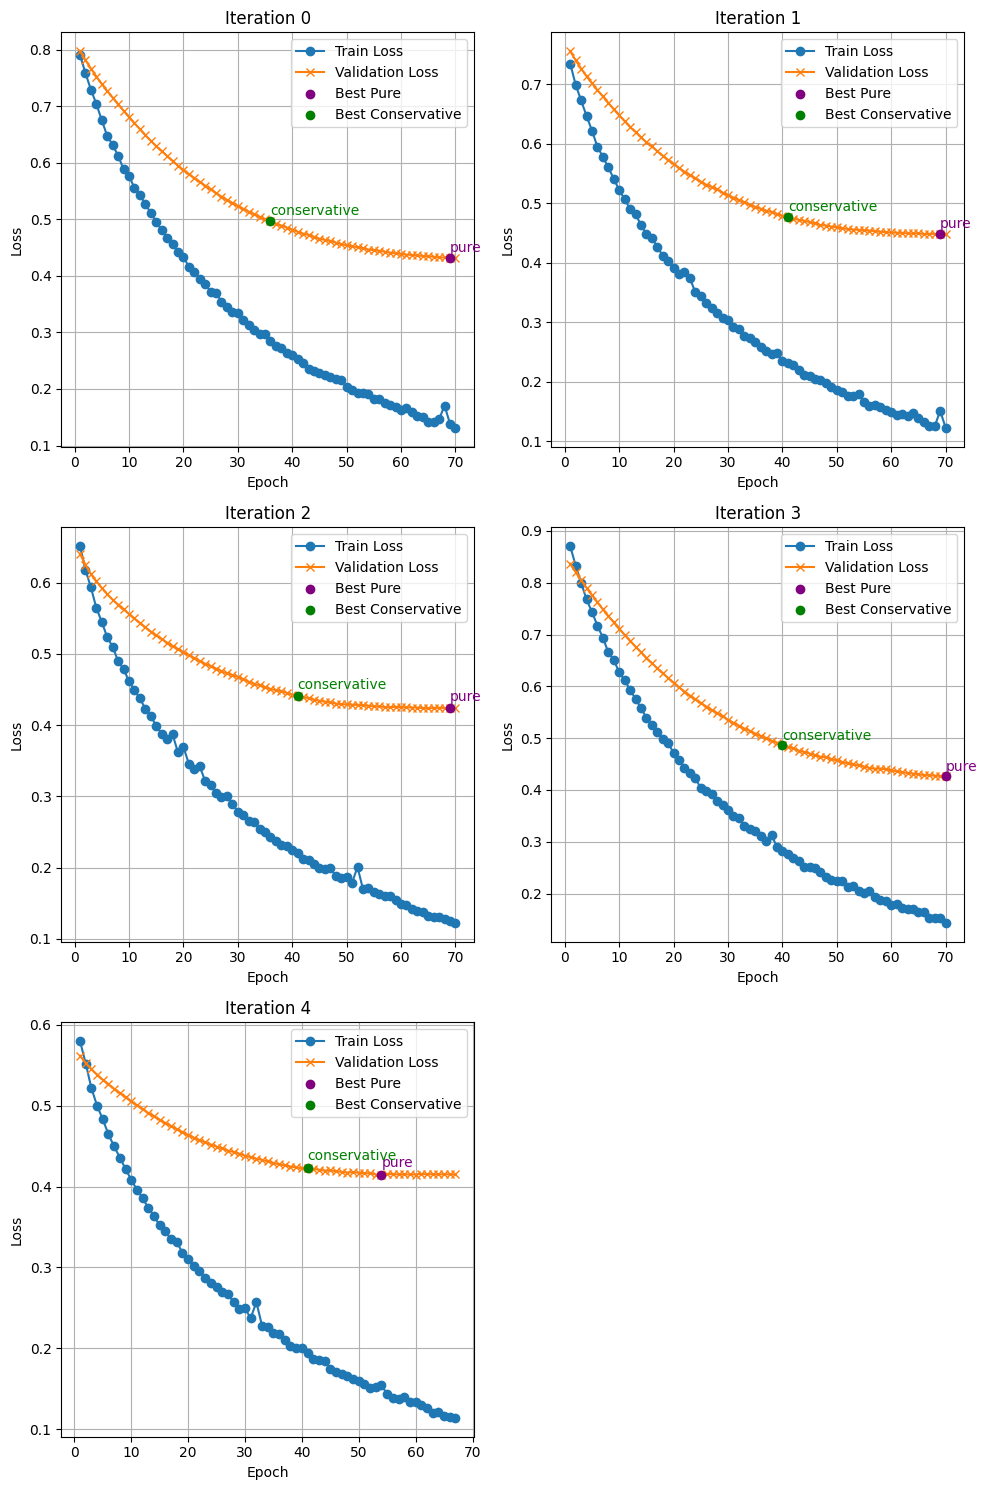

In [57]:
all_train, all_val, best_pure_epochs, best_cons_epochs = [], [], [], []

for iteration_list in pure_vs_conservative:
    # Third item
    all_train.append(iteration_list[2])
    #print(iteration_list[2])

    # Fourth item
    all_val.append(iteration_list[3])
    #print(iteration_list[3])

    # 2nd position of both first and second items
    best_pure_epochs.append(iteration_list[0][1])
    best_cons_epochs.append(iteration_list[1][1])
    #print(iteration_list[0][1])
    #print(iteration_list[1][1])
    #print('---------------------')


plotLossCollection(all_train, all_val, best_pure_epochs, best_cons_epochs)

In [58]:
pure_resnets, conservative_resnets = [], []

for item in pure_vs_conservative:
    pure_resnets.append(item[0][0])
    conservative_resnets.append(item[1][0])

Iteration 0
Pure Method


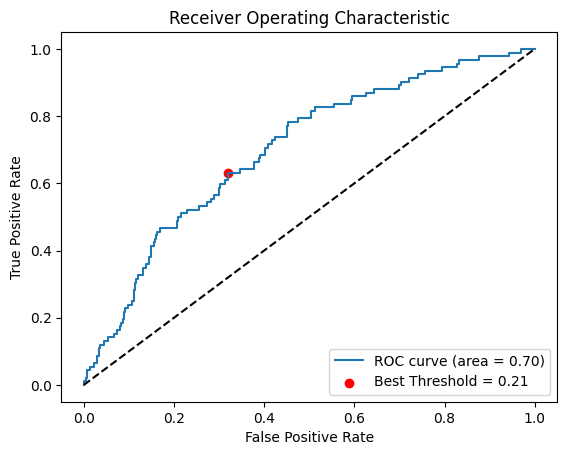

Area Under Curve: 0.7005569529284945
Best Threshold (closest to (0,1)): 0.20733348
Conservative Method


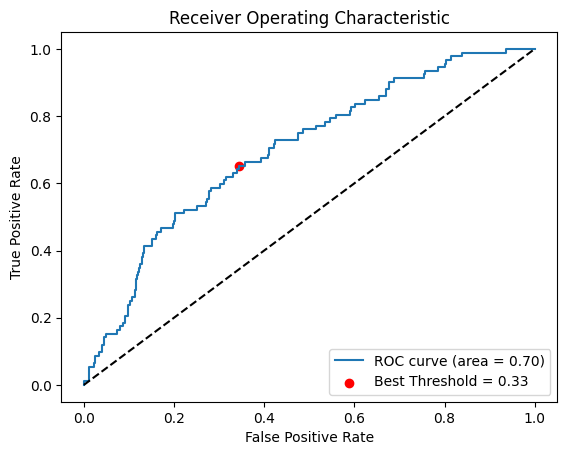

Area Under Curve: 0.6982213438735178
Best Threshold (closest to (0,1)): 0.3316835
----------------------------------------------------
Iteration 1
Pure Method


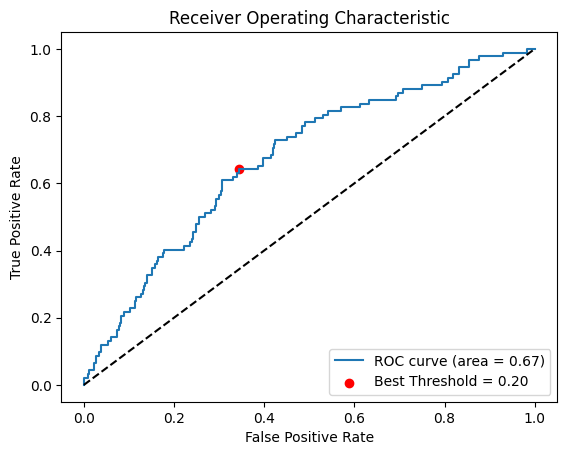

Area Under Curve: 0.6745418613007546
Best Threshold (closest to (0,1)): 0.19514503
Conservative Method


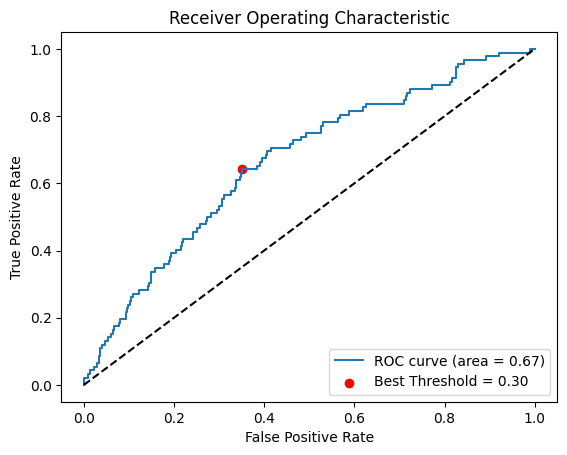

Area Under Curve: 0.6652892561983471
Best Threshold (closest to (0,1)): 0.2952665
----------------------------------------------------
Iteration 2
Pure Method


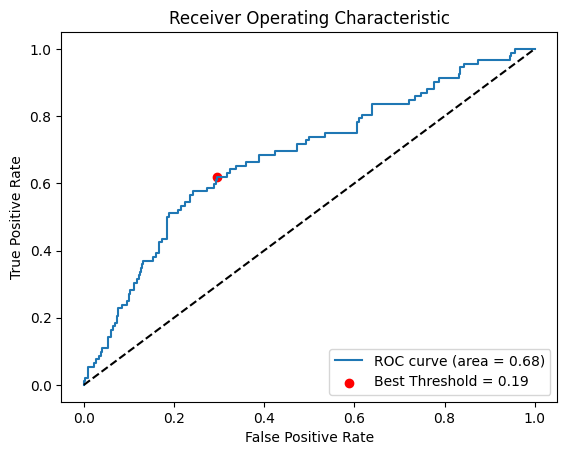

Area Under Curve: 0.6792669780812073
Best Threshold (closest to (0,1)): 0.18572879
Conservative Method


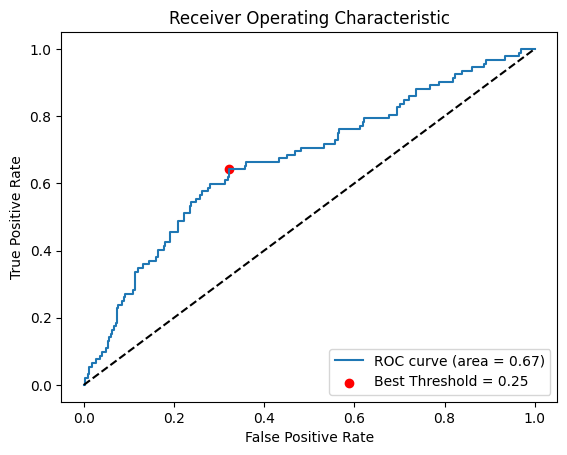

Area Under Curve: 0.6682177506288178
Best Threshold (closest to (0,1)): 0.2529691
----------------------------------------------------
Iteration 3
Pure Method


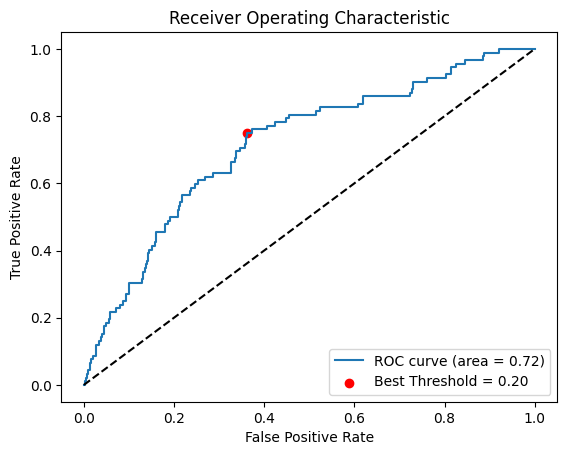

Area Under Curve: 0.7162055335968379
Best Threshold (closest to (0,1)): 0.20308614
Conservative Method


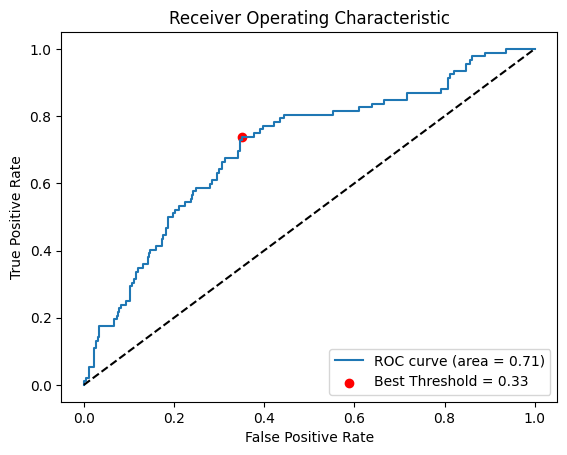

Area Under Curve: 0.7078332734459217
Best Threshold (closest to (0,1)): 0.32812682
----------------------------------------------------
Iteration 4
Pure Method


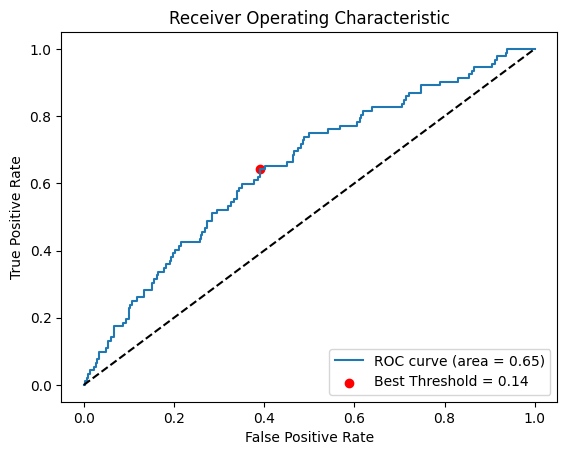

Area Under Curve: 0.6475925260510241
Best Threshold (closest to (0,1)): 0.14442687
Conservative Method


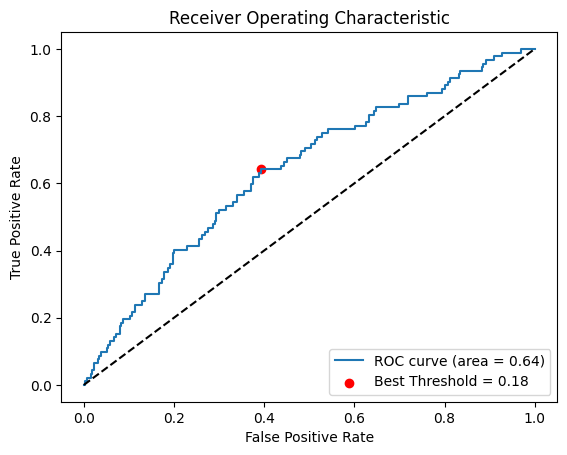

Area Under Curve: 0.6388789076536112
Best Threshold (closest to (0,1)): 0.18333282
----------------------------------------------------


In [59]:
pure_thresh, cons_thresh = [], []

for i in range(len(pure_resnets)):
    print("Iteration",i)
    print("Pure Method")
    threshold_custom, auc_custom = getROC(pure_resnets[i], val_dataset)
    pure_thresh.append(threshold_custom)
    print("Conservative Method")
    if best_cons_epochs[i] != 0: 
        threshold_custom2, auc_custom2 = getROC(conservative_resnets[i], val_dataset)
        cons_thresh.append(threshold_custom2)
    else:
        print("ERROR DUE TO EPOCH==0")
        cons_thresh.append(0)
    print('----------------------------------------------------')

Through visual analysis, it's clear that conservative methods achieve the same AUC, but show higher thresholds, which could mean a better differentiation in classification

In [60]:
for i in range(len(pure_resnets)):
    print("Iteration",i)
    print("Pure Method")
    evalResNet(pure_resnets[i], test_dataset,pure_thresh[i])

    print("\nConservative Method")
    if best_cons_epochs[i] != 0: evalResNet(conservative_resnets[i], test_dataset,cons_thresh[i])
    else: print("ERROR DUE TO EPOCH==0")
    print('----------------------------------------------------')

Iteration 0
Pure Method
Total examples: 648

 --------------------- 

Accuracy for Class 0: 63.94%  (360 in 563)
Accuracy for Class 1: 82.35%  (70 in 85)
Test Accuracy: 66.36%
Weighted Accuracy: 79.90%

 --------------------- 

F1 Score (Macro): 0.579
F1 Score (Weighted): 0.718
F1 Score Class 0: 0.768
F1 Score Class 1: 0.391

 --------------------- 


Confusion Matrix: 
 [[360 203]
 [ 15  70]]

Conservative Method
Total examples: 648

 --------------------- 

Accuracy for Class 0: 60.57%  (341 in 563)
Accuracy for Class 1: 84.71%  (72 in 85)
Test Accuracy: 63.73%
Weighted Accuracy: 81.50%

 --------------------- 

F1 Score (Macro): 0.562
F1 Score (Weighted): 0.696
F1 Score Class 0: 0.744
F1 Score Class 1: 0.380

 --------------------- 


Confusion Matrix: 
 [[341 222]
 [ 13  72]]
----------------------------------------------------
Iteration 1
Pure Method
Total examples: 648

 --------------------- 

Accuracy for Class 0: 59.86%  (337 in 563)
Accuracy for Class 1: 78.82%  (67 in 85)
Te

### Conservative VS Pure Conclusions

Both behave in very similar ways, displaying nearly identical performances. 